In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np

from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import compress


#### Load Recipes Data

In [2]:
recipes = json.load(open('./data/recipe_train.json'))

#### Convert recipe to text document

In [3]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tfidf vectorizer for text data

In [4]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

vectorizer = TfidfVectorizer(use_idf=True)
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [5]:
transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array)
docs_scores_dfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a data frame
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docs_scores_dfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    #one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

Text(0, 0.5, 'Number of Therms')

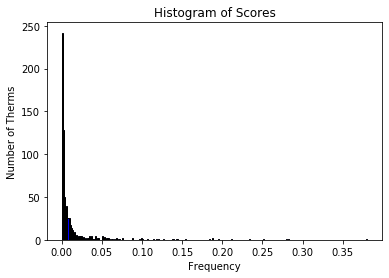

In [6]:
statistics = {}
for k in docs_scores_dfs.keys():
    df = docs_scores_dfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    statistics[k] = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]

irish_scores = docs_scores_dfs["irish"]["score"]
irish_scores = irish_scores.loc[irish_scores>0.0]
plt.hist(irish_scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')
# print(statistics)

#### Top 10 therms per cuisine

In [21]:
for k in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[k]
    print('-------------')
    print(k)
    print(scores_df.iloc[:15,:])


-------------
greek
        term     score
0      fresh  0.297130
1     pepper  0.294340
2        oil  0.287714
3       salt  0.260512
4      olive  0.260163
5       feta  0.231165
6     ground  0.226684
7      lemon  0.224591
8     garlic  0.220058
9     cheese  0.202621
10   oregano  0.162209
11     juice  0.155540
12     dried  0.152750
13  tomatoes  0.147868
14     black  0.139847
-------------
southern_us
       term     score
0      salt  0.374617
1    pepper  0.329929
2     sugar  0.285364
3    butter  0.265297
4     flour  0.227380
5    ground  0.189832
6      eggs  0.170627
7    powder  0.160286
8       oil  0.157209
9       all  0.155608
10  purpose  0.155608
11   baking  0.151546
12     milk  0.137758
13    black  0.124462
14   garlic  0.121507
-------------
filipino
       term     score
0     sauce  0.327662
1    garlic  0.325087
2    pepper  0.323156
3      salt  0.309637
4       oil  0.306418
5    onions  0.252988
6     water  0.224020
7     sugar  0.205352
8       soy  

#### Load Baskets Market Data

In [8]:
baskets = []
with open('./data/groceries.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append([elem.replace(' ', '-') for elem in row])

#### Compute ngram for tf.idf top score 

In [9]:
top_scores_ngram = {}

for cuisine in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[cuisine]
    scores_df = scores_df[scores_df['score']>(statistics[cuisine][1]/4)]
    #scores_df = scores_df.iloc[:30,:]
    scores_df = scores_df.sort_values(by=['score'],ascending=False)
    
    ngram_scores = []
    for index, row in scores_df.iterrows():
        ngram = list(ngrams(row['term'], 3))
        score =  row['score']
        ngram_scores.append([ngram, score])
        
    top_scores_ngram[cuisine] = ngram_scores

#### Define the metric similarity

In [10]:
def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

#### Compute Basket Scores
For each basket we iterate over all items and compute their similarities with the top 
terms in the cuisines docs

In [11]:
baskets_scores = []

for basket in baskets:
    similarities = {}
    for cuisine in top_scores_ngram:
        value = 0
        for item in basket:      
            item_ngram = list(ngrams(item, 3))
            for ngram_term, score in top_scores_ngram[cuisine]:
                sim = 1-jaccard_distance(item_ngram, ngram_term)
                if sim > 0:
                    value += sim * score
                    
        similarities[cuisine] = value    
    baskets_scores.append(similarities)
           
    # print('------------------')
    # print("basket: ", basket)
    # for k in similarities:
    #     print(k, similarities[k]) 

#### CLustering baskets
We now try to cluster the baskets, based on the scores that they 
obtained using frequent therms of recipes

In [12]:
baskets_scores_df = pd.DataFrame(baskets_scores)
X = StandardScaler().fit_transform(baskets_scores_df.to_numpy())

In [13]:
# OPTICS
optics = OPTICS(min_samples=20, max_eps=0.35, xi=.05, min_cluster_size=.05)
optics.fit(X)
optics_labels = optics.labels_[optics.ordering_]
print(set(optics_labels))

{0, 1, 2, 3, 4, 5, 6, -1}


/home/nepotu/anaconda3/envs/dataMiningProject/lib/python3.7/site-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [14]:
# K-Means
kMeans = KMeans(n_clusters=10, random_state=0).fit(X)
kMeans_labels = kMeans.labels_
print(set(kMeans_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
[0.35, 50]


In [ ]:
# DBSCAN 
[eps, min_samples] = [0.35, 50]
dbScan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
dbscan_labels = dbScan.labels_
print(set(dbscan_labels))
print([eps, min_samples])

#### Analysis of the method
Observe size of created basket clusters

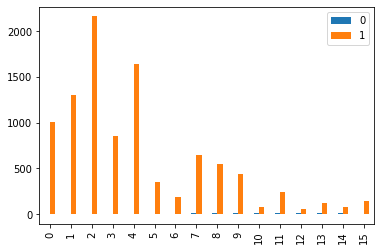

In [15]:
labels = dbscan_labels
cluster_sizes = []
for label in set(labels):
    cluster_sizes.append([label, len(baskets_scores_df[labels == label])])
pd.DataFrame(cluster_sizes).plot(kind='bar')

Select one cluster and calculate its overall score (by summing
all scores of all items of that cluster)

In [16]:
selected_basket_cluster = 2
selected_basket_scores = baskets_scores_df[labels == selected_basket_cluster]
aggregated_basket_cluster_score \
    = np.sum(selected_basket_scores, axis=0)\
    .sort_values(ascending=False)
selected_baskets = list(compress(baskets, labels == selected_basket_cluster))
selected_baskets = [' '.join(l) for l in selected_baskets]
aggregated_basket_cluster_score = aggregated_basket_cluster_score[0:50]
print(aggregated_basket_cluster_score)

mexican         11924.217633
french          10699.738093
greek           10079.091040
indian           9417.729820
japanese         9244.993175
thai             9214.838221
southern_us      8786.262643
irish            8763.852354
brazilian        8715.450252
russian          8670.720719
british          8547.928205
italian          8460.640139
spanish          8380.989785
filipino         8266.829509
vietnamese       7827.465877
chinese          7774.940769
korean           7552.775325
jamaican         7105.843397
cajun_creole     5616.378551
moroccan         5587.755243
dtype: float64


 Calculate the most frequent terms (TF) of the cluster of baskets

In [17]:
countVectorizer = CountVectorizer()
wordCountVector = countVectorizer.fit_transform(selected_baskets)
vocabulary = pd.Series(countVectorizer.vocabulary_)
vocabulary = vocabulary[vocabulary > 0].sort_values(ascending=False)
print(vocabulary)

zwieback     169
yogurt       168
wine         167
whole        166
white        165
            ... 
baby           5
artif          4
articles       3
appetizer      2
alcohol        1
Length: 169, dtype: int64


 Compute the intersection between frequent terms of baskets clusters 
 and cuisine terms that scored high TF-IDF

In [18]:
intersection_therms = {}
frequent_basket_cluster_terms = set(vocabulary.index)
for cuisine in aggregated_basket_cluster_score.index:
    frequent_cuisine_therms = set(docs_scores_dfs[cuisine]["term"][0:50])
    print(len(frequent_basket_cluster_terms.intersection(frequent_cuisine_therms)))
    

15
18
16
16
14
13
20
23
21
20
24
18
14
19
13
16
16
18
13
10


#### Baseline method - K-means
Now we will implement the baseline algorithm to compare our method with. 
A KNN method will be used. We will try to find the best K by trial and error based on the
coherence of the results because there are not many possible Ks for the given dataset.

In [19]:
baskets_as_docs = [' '.join(basket) for basket in baskets]
X = vectorizer.fit_transform(baskets_as_docs)
model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
baseline_labels = model.labels_
for i in range(len(set(labels))):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 soda
 pastry
 water
 bottled
 waffles
 sausage
 beverages
 frankfurter
 coffee
 fruit
Cluster 1:
 fruit
 yogurt
 cream
 newspapers
 bread
 coffee
 cheese
 pastry
 beverages
 tropical
Cluster 2:
 buns
 rolls
 milk
 soda
 whole
 sausage
 bottled
 frankfurter
 yogurt
 vegetables
Cluster 3:
 shopping
 bags
 soda
 vegetables
 milk
 canned
 beer
 fruit
 sausage
 buns
Cluster 4:
 juice
 vegetable
 fruit
 milk
 vegetables
 whole
 bottled
 soda
 cheese
 yogurt
Cluster 5:
 vegetables
 other
 root
 fruit
 milk
 whole
 frozen
 cream
 cheese
 yogurt
Cluster 6:
 milk
 whole
 butter
 fruit
 yogurt
 pastry
 bread
 newspapers
 bottled
 brown
Cluster 7:
 chocolate
 specialty
 marshmallow
 soda
 candy
 vegetables
 milk
 bottled
 whole
 rolls
Cluster 8:
 bar
 snack
 salty
 specialty
 cake
 soda
 milk
 vegetables
 whole
 rolls
Cluster 9:
 beer
 canned
 bottled
 water
 soda
 liquor
 vegetables
 milk
 newspapers
 whole
Cluster 10:


IndexError: index 10 is out of bounds for axis 0 with size 10

#### Compute Scores of Baskets crated using K-Means
For the created clusters of baskets using the baseline method, 
we calculate its scores in terms of similarity with the terms
that scored high TF-IDF for the cuisines

In [ ]:
    # print('------------------')
    # print("basket: ", basket)
    # for k in similarities:
    #     print(k, similarities[k]) 